In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn
import os
import warnings
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning

import decomposition
import scaler
import potential_data
import plots
import fit

pd.options.mode.chained_assignment = None
warnings.simplefilter("ignore", OptimizeWarning)
warnings.simplefilter("ignore", RuntimeWarning)

                    r/a   T     aV(r)       err
decomposition type                             
mod                   1   2  0.896977  0.000027
mod                   1   3  0.892851  0.000043
mod                   1   4  0.890921  0.000084
mod                   1   5  0.890038  0.000190
mod                   1   6  0.889162  0.000457
...                 ...  ..       ...       ...
mod                  12   7  0.497600  0.268885
mod                  12   8  0.544970  0.773326
mod                  12   9  0.292924  1.068194
mod                  12  10  0.332461  2.027981
mod                  12  11 -1.809837  1.906042

[120 rows x 4 columns]
                    r/a     aV(r)       err
decomposition type                         
mod                   1  0.890038  0.000190
mod                   2  1.234457  0.001721
mod                   3  1.370961  0.004506
mod                   4  1.425437  0.007360
mod                   5  1.464739  0.010130
mod                   6  1.473608  0.012718


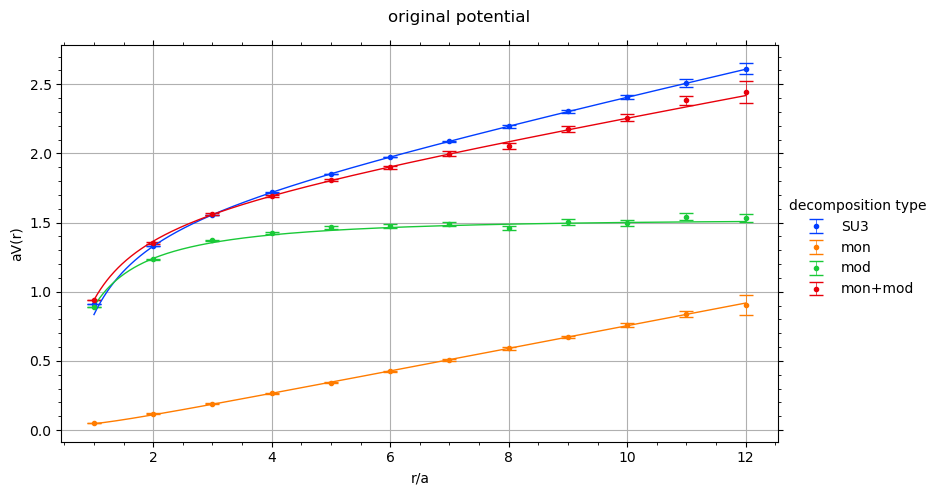

In [16]:
image_path = f'../../images/potential_gevp/su3/gluodynamics/'
image_name = f'potentials'
paths_monopole = [{'path': '../../result/potential_gevp/adjoint/on-axis/su3/gluodynamics/24^4/beta6.0/monopole/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_0/copies=20/potential.csv',
          'parameters': {'decomposition type': 'mon'}}]
df_monopole = potential_data.get_potantial_df(paths_monopole, coluns_to_multiindex=['decomposition type'])
df_monopole = df_monopole.rename({'potential': 'aV(r)', 'space_size': 'r/a', 'time_size': 'T'}, axis=1)
# print(df_monopole)
df_monopole = df_monopole[df_monopole['aV(r)'] != 0]
index = []
if df_monopole.index.names[0] is not None:
    index = df_monopole.index.names
df_monopole = df_monopole.set_index(['r/a'], append=True).groupby(index + ['r/a']).apply(fit.potential_fit_T_range, fit.func_double_exponent, ['V', 'a', 'b', 'c', 'd'], 8, include_groups=False).reset_index(level=['r/a']).reset_index(level=-1, drop=True)
df_monopole = df_monopole.drop('T', axis = 1)
# print(df_monopole)
paths_original = [{'path': '../../result/potential_gevp/adjoint/on-axis/su3/gluodynamics/24^4/beta6.0/original/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential.csv',
          'parameters': {'decomposition type': 'SU3'}}]
df_original = potential_data.get_potantial_df(paths_original, coluns_to_multiindex=['decomposition type'])
df_original = df_original.rename({'potential': 'aV(r)', 'space_size': 'r/a', 'time_size': 'T'}, axis=1)
# print(df_original)
df_original = df_original[df_original['aV(r)'] != 0]
index = []
if df_original.index.names[0] is not None:
    index = df_original.index.names
df_original = df_original.set_index(['r/a'], append=True).groupby(index + ['r/a']).apply(fit.potential_fit_T_range, fit.func_constant, ['V'], 3, include_groups=False).reset_index(level=['r/a']).reset_index(level=-1, drop=True)
df_original = df_original.drop('T', axis = 1)
# print(df_original)
paths_monopoless = [{'path': '../../result/potential_gevp/adjoint/on-axis/su3/gluodynamics/24^4/beta6.0/monopoless/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_0/copies=20/potential.csv',
          'parameters': {'decomposition type': 'mod'}}]
df_monopoless = potential_data.get_potantial_df(paths_monopoless, coluns_to_multiindex=['decomposition type'])
df_monopoless = df_monopoless.rename({'potential': 'aV(r)', 'space_size': 'r/a', 'time_size': 'T'}, axis=1)
print(df_monopoless)
df_monopoless = df_monopoless[df_monopoless['aV(r)'] != 0]
index = []
if df_monopoless.index.names[0] is not None:
    index = df_monopoless.index.names
df_monopoless = df_monopoless[df_monopoless['T'] == 5]
df_monopoless = df_monopoless.drop('T', axis = 1)
print(df_monopoless)
df_sum = df_monopole
df_sum = df_sum.reset_index(level='decomposition type')
print(df_sum)
df_sum['decomposition type'] = 'mon+mod'
print(df_sum)
print(df_sum.loc[:, 'aV(r)'])
print(df_monopoless.loc[:, 'aV(r)'])
df_sum.loc[:, 'err'] = np.sqrt(df_monopole.loc[:, 'err'].array**2 + df_monopoless.loc[:, 'err'].array**2)
df_sum.loc[:, 'aV(r)'] = df_monopole.loc[:, 'aV(r)'].array + df_monopoless.loc[:, 'aV(r)'].array
df_sum = df_sum.set_index(['decomposition type'], drop=True)
print(df_sum)
df = pd.concat([df_original, df_monopole, df_monopoless, df_sum])
df_fit = df.groupby(index).apply(fit.make_fit_range, fit.func_cornell, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', 'err', range_min_len=6, include_groups=False).reset_index(level=-1, drop=True)
df_fit = df_fit.groupby(index).apply(fit.average_fit_p_value, ['V0', 'alpha', 'sigma'], 'r/a', include_groups=False).reset_index(level=-1, drop=True)
index_fit = []
if df.index.names[0] is not None:
    index_fit = df.index.names
print(df_fit)
df_curves = df_fit.groupby(index_fit).apply(fit.make_fit_curve, fit.func_cornell, 'r/a', 'aV(r)', ['V0', 'alpha', 'sigma'], include_groups=False).reset_index(level=-1, drop=True)
df = df.reset_index(level=index)
df_curves = df_curves.reset_index(level=index)
# df = df[df['err'] < 0.3]
plots.plot_potential_single(df, 'r/a', 'aV(r)', 'decomposition type', 'r/a', 'aV(r)', 'original potential', image_path, image_name, True, err='err', df_fits=df_curves)

In [2]:
def potential_fits(df, reset=[]):
    df_fit = df.groupby(df.index.names).apply(fit.make_fit_range, fit.func_cornell, 6, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err').reset_index(level=-1, drop=True)
    df_fit = df_fit.groupby(df_fit.index.names).apply(fit.average_fit_p_value, ['V0', 'alpha', 'sigma'], 'r/a').reset_index(level=-1, drop=True)
    df_curves = df_fit.groupby(df_fit.index.names).apply(fit.make_fit_curve, fit.func_cornell, 'r/a', 'aV(r)', ['V0', 'alpha', 'sigma']).reset_index(level=-1, drop=True)
    df_fit = df_fit.reset_index(level=reset)
    df_curves = df_curves.reset_index(level=reset)
    return df_fit, df_curves

                         smearing_step  r/a  copy  T     aV(r)       err  \
beta decomposition_type                                                    
6.0  original                       30    1     0  1  0.058437  0.000118   
     original                       30    1     0  2  0.054148  0.000118   
     original                       30    1     0  3  0.053002  0.000108   
     original                       30    1     0  4  0.052565  0.000104   
     original                       30    1     0  5  0.052417  0.000115   
...                                ...  ...   ... ..       ...       ...   
     mod                            30    8     1  3  0.769523  0.000719   
     mod                            30    8     1  4  0.750662  0.001517   
     mod                            30    8     1  5  0.740552  0.002659   
     mod                            30    8     1  6  0.730730  0.003074   
     mod                            30    8     1  7  0.734854  0.007803   

           

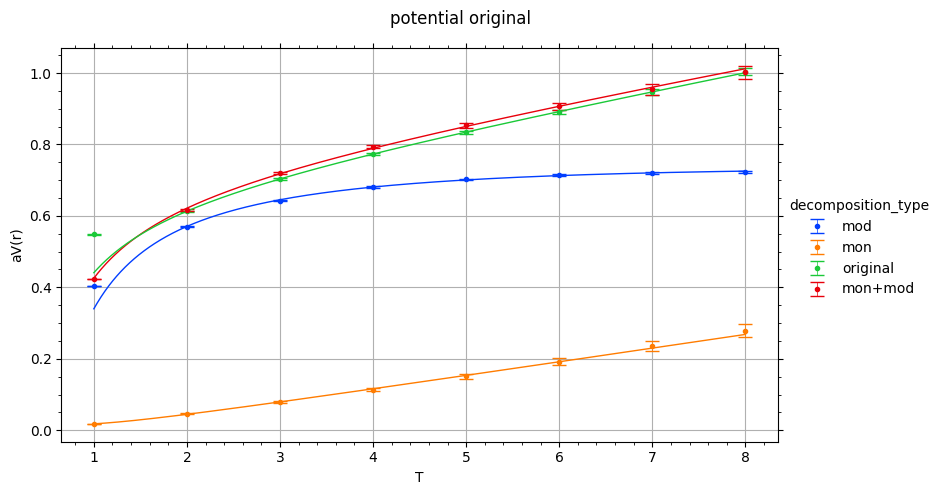

In [3]:
paths_APE = [{'path': '../../result/smearing/binning/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/16^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'beta': 6.0, 'decomposition_type': 'original'}, 'constraints': {'r/a': (1, 8), 'T': (1, 7), 'smearing_step': (30, 30), 'bin_size': (103, 103)}}]
paths = [{'path': '../../result/smearing/binning/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/16^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.6/potential_original.csv',
          'parameters': {'beta': 6.0, 'decomposition_type': 'original'}, 'constraints': {'r/a': (1, 8), 'T': (1, 7), 'smearing_step': (30, 30), 'bin_size': (103, 103)}},
          {'path': '../../result/smearing/binning/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/16^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.6/steps_0/copies=20/potential_monopole.csv',
          'parameters': {'beta': 6.0, 'decomposition_type': 'mon'}, 'constraints': {'r/a': (1, 8), 'T': (1, 7), 'smearing_step': (30, 30), 'bin_size': (103, 103), 'copy': (1, 1)}},
          {'path': '../../result/smearing/binning/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/16^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.6/steps_0/copies=20/potential_monopoless.csv',
          'parameters': {'beta': 6.0, 'decomposition_type': 'mod'}, 'constraints': {'r/a': (1, 8), 'T': (1, 7), 'smearing_step': (30, 30), 'bin_size': (103, 103), 'copy': (1, 1)}}]
df = potential_data.get_potantial_df(paths)
df_APE = potential_data.get_potantial_df(paths_APE)
print(df)
df = df.groupby(df.index.names + ['r/a']).apply(fit.potential_fit_T_range, 5).reset_index(level=['r/a']).reset_index(level=-1, drop=True)
df = df.reset_index(level='decomposition_type')
df = potential_data.find_sum(df, 'mon', 'mod')
df = df.set_index('decomposition_type')
df_APE = df_APE.groupby(df_APE.index.names + ['r/a']).apply(fit.potential_fit_T_range, 5).reset_index(level=['r/a']).reset_index(level=-1, drop=True)
print(df)
df_fit, df_curves = potential_fits(df, reset=['decomposition_type'])
df_fit_APE, df_curves_APE = potential_fits(df, reset=['decomposition_type'])
df = df.reset_index(level='decomposition_type')
V, V_err = fit.fit_curve_shift(df_APE, df_fit.loc[df_fit['decomposition_type'] == 'original', ['V0', 'alpha', 'sigma']].values[0], 'r/a', 'aV(r)', 'err', fit.func_cornell)
print('V', V, V_err)
df.loc[df['decomposition_type'] == 'original', 'aV(r)'] = df.loc[df['decomposition_type'] == 'original', 'aV(r)'] + V
df.loc[df['decomposition_type'] == 'original', 'err'] = np.sqrt(df.loc[df['decomposition_type'] == 'original', 'err'] ** 2 + V_err ** 2)
print(df)
df_curves.loc[df_curves['decomposition_type'] == 'original', 'aV(r)'] = df_curves.loc[df_curves['decomposition_type'] == 'original', 'aV(r)'] + V
image_path = '../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0'
plots.plot_potential_single(df, 'r/a', 'aV(r)', 'decomposition_type', 'T', 'aV(r)', 'potential original', image_path, f'potential_decomposition_steps_0_copies=20_copy=1', True, err='err', df_fits=df_curves)

In [ ]:
show_plot = True
coordinate = 'r/a'
hue = 'beta'
groupby = []
paths = [{'path': '../../result/smearing/binning/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/16^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.6/steps_0/copies=20/potential_monopoless.csv',
          'parameters': {'beta': 6.0}, 'constraints': {'r/a': (1, 8), 'T': (1, 7), 'smearing_step': (30, 30), 'bin_size': (103, 103)}},
          {'path': '../../result/smearing/binning/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/16^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.6/steps_0/copies=20/potential_monopole.csv',
          'parameters': {'beta': 6.0}, 'constraints': {'r/a': (1, 8), 'T': (1, 7), 'smearing_step': (30, 30), 'bin_size': (103, 103)}},
          {'path': '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/16^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv',
          'parameters': {'beta': 6.0}, 'constraints': {'r/a': (1, 12), 'T': (1, 11), }}]
image_path = f'../../images/potential/su3/gluodynamics/'
image_name = f'beta_comparison'
df = potential_data.get_potantial_df(paths)
df = df.groupby(df.index.names + ['r/a', 'bin_size', 'copy']).apply(fit.potential_fit_T_range, 5).reset_index(level=['r/a', 'bin_size', 'copy']).reset_index(level=-1, drop=True)
print(df)
plots.plot_potential_single(df, 'r/a', 'aV(r)', 'copy', 'T', 'aV(r)', 'potential original', image_path, f'potential_monopole', show_plot, err='err')
df_fit = df.groupby(df.index.names + ['bin_size', 'copy']).apply(fit.make_fit_range, fit.func_cornell, 6, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err').reset_index(level=-1, drop=True)
print(df_fit)
df_fit = df_fit.groupby(df_fit.index.names).apply(fit.average_fit_p_value, ['V0', 'alpha', 'sigma'], 'r/a').reset_index(level=-1, drop=True).reset_index(level=['bin_size', 'copy'])
print(df_fit)
df_curves = df_fit.groupby(df_fit.index.names + ['bin_size', 'copy']).apply(fit.make_fit_curve, fit.func_cornell, 'r/a', 'aV(r)', ['V0', 'alpha', 'sigma']).reset_index(level=-1, drop=True).reset_index(level=['bin_size', 'copy'])
print(df_curves)

plots.plot_potential_single(df_fit, 'copy', 'sigma', None, 'copy', 'sigma', 'string tension', f'../../images/potential/su3/gluodynamics/', 'string_tension', show_plot, err='sigma_err')
plots.plot_potential_single(df_fit, 'copy', 'alpha', None, 'copy', 'alpha', 'string tension', f'../../images/potential/su3/gluodynamics/', 'string_tension', show_plot, err='alpha_err')

(<matplotlib.lines.Line2D object at 0x7f9bda1f3220>, (<matplotlib.lines.Line2D object at 0x7f9bda1f38e0>, <matplotlib.lines.Line2D object at 0x7f9bda1f3970>), (<matplotlib.collections.LineCollection object at 0x7f9bda1f3370>,))
(<matplotlib.lines.Line2D object at 0x7f9bda19d880>, (<matplotlib.lines.Line2D object at 0x7f9bda19ddf0>, <matplotlib.lines.Line2D object at 0x7f9bda19de80>), (<matplotlib.collections.LineCollection object at 0x7f9bda194d60>,))
(<matplotlib.lines.Line2D object at 0x7f9bda13bbb0>, (<matplotlib.lines.Line2D object at 0x7f9bda1493a0>, <matplotlib.lines.Line2D object at 0x7f9bda149430>), (<matplotlib.collections.LineCollection object at 0x7f9bda13bd30>,))
(<matplotlib.lines.Line2D object at 0x7f9bda15d280>, (<matplotlib.lines.Line2D object at 0x7f9bda15da60>, <matplotlib.lines.Line2D object at 0x7f9bda15daf0>), (<matplotlib.collections.LineCollection object at 0x7f9bda15d3d0>,))
(<matplotlib.lines.Line2D object at 0x7f9bda0f88b0>, (<matplotlib.lines.Line2D object at

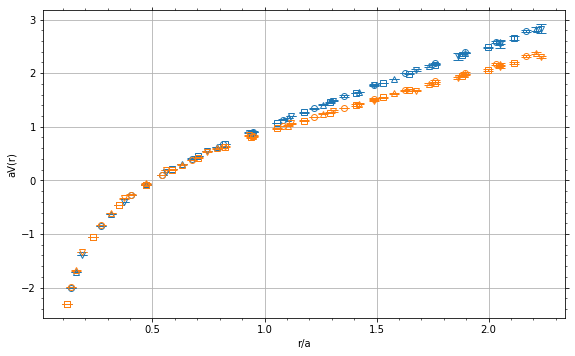

../../images/potential/su3/gluodynamics/decomposition/original_sum_beta


In [2]:
path1 = '../../result/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics'
paths = [{'original': {'path' : f'{path1}/24^4/beta6.0/HYP0_APE_alpha=0.5/potential_original.csv', 'parameters': {'beta': 6.0, 'name': 'SU(3)'}, 'constraints': {'r/a': (1, 12), 'T': (1, 12)}},
        'monopole': {'path' : f'{path1}/24^4/beta6.0/HYP0_APE_alpha=0.5/steps_500/copies=4/potential_monopole.csv', 'parameters': {'beta': 6.0, 'name': 'mon'}, 'constraints': {'r/a': (1, 12), 'T': (11, 11)}},
        'monopoless': {'path' : f'{path1}/24^4/beta6.0/HYP0_APE_alpha=0.5/steps_500/copies=4/potential_monopoless.csv', 'parameters': {'beta': 6.0, 'name': 'mod'}, 'constraints': {'r/a': (1, 12), 'T': (8, 8)}}},
        {'original': {'path' : f'{path1}/28^4/beta6.1/HYP0_APE_alpha=0.5/potential_original.csv', 'parameters': {'beta': 6.1, 'name': 'SU(3)'}, 'constraints': {'r/a': (1, 14), 'T': (1, 14)}},
        'monopole': {'path' : f'{path1}/28^4/beta6.1/HYP0_APE_alpha=0.5/steps_500/copies=3/potential_monopole.csv', 'parameters': {'beta': 6.1, 'name': 'mon'}, 'constraints': {'r/a': (1, 14), 'T': (13, 13)}},
        'monopoless': {'path' : f'{path1}/28^4/beta6.1/HYP0_APE_alpha=0.5/steps_500/copies=3/potential_monopoless.csv', 'parameters': {'beta': 6.1, 'name': 'mod'}, 'constraints': {'r/a': (1, 14), 'T': (8, 8)}}},
        {'original': {'path' : f'{path1}/32^4/beta6.2/HYP0_APE_alpha=0.5/potential_original.csv', 'parameters': {'beta': 6.2, 'name': 'SU(3)'}, 'constraints': {'r/a': (1, 16), 'T': (1, 16)}},
        'monopole': {'path' : f'{path1}/32^4/beta6.2/HYP0_APE_alpha=0.5/steps_500/copies=3/potential_monopole.csv', 'parameters': {'beta': 6.2, 'name': 'mon'}, 'constraints': {'r/a': (1, 16), 'T': (15, 15)}},
        'monopoless': {'path' : f'{path1}/32^4/beta6.2/HYP0_APE_alpha=0.5/steps_500/copies=3/potential_monopoless.csv', 'parameters': {'beta': 6.2, 'name': 'mod'}, 'constraints': {'r/a': (1, 16), 'T': (8, 8)}}},
        {'original': {'path' : f'{path1}/36^4/beta6.3/HYP0_APE_alpha=0.5/potential_original.csv', 'parameters': {'beta': 6.3, 'name': 'SU(3)'}, 'constraints': {'r/a': (1, 18), 'T': (1, 18)}},
        'monopole': {'path' : f'{path1}/36^4/beta6.3/HYP0_APE_alpha=0.5/steps_500/copies=4/potential_monopole.csv', 'parameters': {'beta': 6.3, 'name': 'mon'}, 'constraints': {'r/a': (1, 18), 'T': (17, 17)}},
        'monopoless': {'path' : f'{path1}/36^4/beta6.3/HYP0_APE_alpha=0.5/steps_500/copies=4/potential_monopoless.csv', 'parameters': {'beta': 6.3, 'name': 'mod'}, 'constraints': {'r/a': (1, 18), 'T': (8, 8)}}}]
data_beta = []
for path in paths:
    data = potential_data.DataDecomposition(path)
    data.fit_original_T((2, 8))
    data.df = data.df.drop('T', axis = 1)
    data.find_sum('monopole', 'monopoless')
    data.remove_from_plot(['monopole', 'monopoless'])
    r0 = scaler.get_r0(path['original']['parameters']['beta'])
    data.scale_potentials(r0)
    popt, pcov = fit.fit_single(data.df[data.df['potential_type'] == 'original'], (3*r0, 18*r0), fit.func_quark_potential)
    data.df['aV(r)'] = data.df['aV(r)'] - fit.func_quark_potential(0.5, *popt)
    data_beta.append(data.df)
data_beta = pd.concat(data_beta)
data_beta.loc[data_beta['beta'] == 6.0, 'marker'] = 'v'
data_beta.loc[data_beta['beta'] == 6.1, 'marker'] = '^'
data_beta.loc[data_beta['beta'] == 6.2, 'marker'] = 'o'
data_beta.loc[data_beta['beta'] == 6.3, 'marker'] = 's'
# print(data_beta)
plots.plot_potential_err_markers(data_beta, 'r/a', 'aV(r)', 'err', ['name', 'beta'], 'r/a', 'aV(r)', 'original potential', f'../../images/potential/su3/gluodynamics/decomposition', 'original_sum_beta', True)


In [2]:
def get_latttice_spacing_su3(beta):
    return 0.5 * scaler.get_r0(beta)

def get_lattice_size(beta, size):
    return get_latttice_spacing_su3(beta) * size

In [3]:
beta_arr = [6, 6, 6, 6.1, 6.2, 6.3, 6.4]
size_arr = [16, 24, 32, 28, 32, 36, 40]
for i in range(len(beta_arr)):
    print(beta_arr[i], 1/scaler.get_r0(beta_arr[i]), get_latttice_spacing_su3(beta_arr[i]), size_arr[i], get_lattice_size(beta_arr[i], size_arr[i]))

6 5.367702622812138 0.09314972067846226 16 1.4903955308553962
6 5.367702622812138 0.09314972067846226 24 2.2355932962830942
6 5.367702622812138 0.09314972067846226 32 2.9807910617107924
6.1 6.336355747797897 0.07890971086555033 28 2.2094719042354094
6.2 7.382899148340123 0.06772407288164212 32 2.1671703322125477
6.3 8.513427304567733 0.058730753445411295 36 2.1143071240348066
6.4 9.741500877672125 0.0513267930967412 40 2.053071723869648


In [ ]:
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics'
params = 'steps_500/copies=3'
compensate = 'compensate_1'
r_max = 18
T_max = 11
y_lims = (-2, 3)
constraints = {'r/a': (1, r_max), 'T': (1, T_max)}
paths = []
# param_arr = ['steps_25/copies=4', 'steps_50/copies=4',
#              'steps_100/copies=4', 'steps_200/copies=4',
#              'steps_1000/copies=4', 'steps_2000/copies=4']
param_arr = ['steps_25/copies=4']
for params in param_arr:
    paths.append({'beta': 6.0, 'fit_range': (2, 12),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/24^4/beta6.0/HYP0_APE_alpha=0.5/potential/potential_original.csv', 'T' : 6, 'constraints': {'r/a': (1, 11), 'T': (1, 11)}},
        'monopole': {'name' : 'mon', 'path' : f'{path1}/24^4/beta6.0/HYP0_APE_alpha=0.5/{params}/potential/potential_monopole.csv', 'T' : 11, 'constraints': {'r/a': (1, 11), 'T': (1, 11)}},
        'monopoless': {'name' : 'mod', 'path' : f'{path1}/24^4/beta6.0/HYP0_APE_alpha=0.5/{params}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': {'r/a': (1, 11), 'T': (1, 11)}}}})
remove_from_plot = ['monopole', 'monopoless']
term = 'mon+mod'

decomposition.potential_together_shifted(paths, f'../../images/potential/together/su3/gluodynamics/beta_dependence', f'potential_mon_mod', y_lims, False, remove_from_plot, False, term, 'sum')

In [ ]:
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics'
params = 'steps_500/copies=3'
compensate = 'compensate_1'
r_max = 18
T_max = 11
y_lims = (-2, 3)
constraints = {'r/a': (1, r_max), 'T': (1, T_max)}
paths = [{'beta': 6.0, 'fit_range': (2, 12),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 12), 'T': (1, 12)}},
        'monopole': {'name' : 'mon', 'path' : f'{path1}/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 11, 'constraints': {'r/a': (1, 12), 'T': (1, 12)}},
        'monopoless': {'name' : 'mod', 'path' : f'{path1}/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': {'r/a': (1, 12), 'T': (1, 12)}}}},
        {'beta': 6.1, 'fit_range': (2, 14),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/28^4/beta6.1/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 14), 'T': (1, 13)}},
        'monopole': {'name' : 'mon', 'path' : f'{path1}/28^4/beta6.1/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 11, 'constraints': {'r/a': (1, 14), 'T': (1, 13)}},
        'monopoless': {'name' : 'mod', 'path' : f'{path1}/28^4/beta6.1/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': {'r/a': (1, 14), 'T': (1, 13)}}}},
        {'beta': 6.2, 'constraints': {'r/a': (1, 16), 'T': (1, 15)}, 'fit_range': (2, 16),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/32^4/beta6.2/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 16), 'T': (1, 15)}},
        'monopole': {'name' : 'mon', 'path' : f'{path1}/32^4/beta6.2/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 11, 'constraints': {'r/a': (1, 16), 'T': (1, 15)}},
        'monopoless': {'name' : 'mod', 'path' : f'{path1}/32^4/beta6.2/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': {'r/a': (1, 16), 'T': (1, 15)}}}},
        {'beta': 6.3, 'constraints': {'r/a': (1, 18), 'T': (1, 17)}, 'fit_range': (2, 18),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 18), 'T': (1, 17)}},
        'monopole': {'name' : 'mon', 'path' : f'{path1}/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 11, 'constraints': {'r/a': (1, 18), 'T': (1, 17)}},
        'monopoless': {'name' : 'mod', 'path' : f'{path1}/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': {'r/a': (1, 18), 'T': (1, 17)}}}}]
fit_range = (2, 12)
remove_from_plot = ['monopole', 'monopoless']
term = 'mon+mod'

decomposition.potential_together_shifted(paths, f'../../images/potential/together/su3/gluodynamics/beta_dependence', f'potential_mon_mod', y_lims, False, remove_from_plot, False, term, 'sum')

In [ ]:
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics'
size = '24^4'
params = 'steps_500/copies=3'
compensate = 'compensate_1'
r_max = 18
T_max = 11
y_lims = (-2, 3)
constraints = {'r/a': (1, r_max), 'T': (1, T_max)}
paths = [{'beta': 6.0, 'fit_range': (2, 12),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 11), 'T': (1, 12)}},
        'abelian': {'name' : 'abelian', 'path' : f'{path1}/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/potential/potential_abelian.csv', 'T' : 8, 'constraints': {'r/a': (1, 12), 'T': (1, 11)}}}},
        {'beta': 6.1, 'fit_range': (2, 14),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/28^4/beta6.1/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 13), 'T': (1, 13)}},
        'abelian': {'name' : 'abelian', 'path' : f'{path1}/28^4/beta6.1/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/potential/potential_abelian.csv', 'T' : 8, 'constraints': {'r/a': (1, 14), 'T': (1, 13)}}}},
        {'beta': 6.2, 'constraints': {'r/a': (1, 16), 'T': (1, 15)}, 'fit_range': (2, 16),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/32^4/beta6.2/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 15), 'T': (1, 15)}},
        'abelian': {'name' : 'abelian', 'path' : f'{path1}/32^4/beta6.2/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/potential/potential_abelian.csv', 'T' : 8, 'constraints': {'r/a': (1, 16), 'T': (1, 15)}}}},
        {'beta': 6.3, 'constraints': {'r/a': (1, 18), 'T': (1, 17)}, 'fit_range': (2, 18),
        'data': {'original': {'name' : 'SU3', 'path' : f'{path1}/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': {'r/a': (1, 17), 'T': (1, 17)}},
        'abelian': {'name' : 'abelian', 'path' : f'{path1}/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/potential/potential_abelian.csv', 'T' : 8, 'constraints': {'r/a': (1, 18), 'T': (1, 17)}}}}]
fit_range = (2, r_max)
remove_from_plot = []
term = 'SU3'

decomposition.potential_together_shifted(paths, f'../../images/potential/together/su3/gluodynamics/beta_dependence', f'potential_abelian', y_lims, False, remove_from_plot, False, term, 'abelian')

In [ ]:
r_max = 20
constraints = {'r/a': (1, r_max)}
fit_range = (10, 20)
mu_arr = ['mu0.45']
paths = []
r0 = 9.8
y_lims = (0, 0.6)
for mu in mu_arr:
    path = f'../../result/potential/wilson_loop/fundamental/su2/qc2dstag/40^4/{mu}'
    paths.append({'name' : 'SU2', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_monopole.csv', 'T': 15, 'constraints': constraints, })
decomposition.potentials_fit(paths, 'SU2', fit_range, r0, y_lims,  f'../../images/potential/decomposition/su2/qc2dstag/40^4/{mu}', 'potential_fit')

In [ ]:
r_max = 20
constraints = {'r/a': (1, r_max)}
fit_range = (5, 20)
mu_arr = ['mu0.35']
paths = []
r0 = 9.8
y_lims = (0, 0.6)
for mu in mu_arr:
    path = f'../../result/potential/wilson_loop/fundamental/su2/qc2dstag/40^4/{mu}'
    paths.append({'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_monopole.csv', 'T': 15, 'constraints': constraints, })
decomposition.potentials_fit(paths, 'SU2', fit_range, r0, y_lims,  f'../../images/potential/decomposition/su2/qc2dstag/40^4/{mu}', 'potential_fit')

In [ ]:
r_max = 17
constraints = {'r/a': (1, r_max)}
fit_range = (8, r_max)
mu_arr = ['mu0.40', 'mu0.45']
paths = []
r0 = 9.8
y_lims = (0, 0.6)
for mu in mu_arr:
    path = f'../../result/potential/wilson_loop/fundamental/su2/qc2dstag/40^4/{mu}'
    paths.append({'name' : 'SU2', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'constraints': constraints})
decomposition.potentials_fit(paths, 'SU2', fit_range, r0, y_lims,  f'../../images/potential/decomposition/su2/qc2dstag/40^4/{mu}', 'potential_fit')

In [ ]:
def make_plot_decomposition_su2(path1, size, beta, beta_str, params, compensate, r_max, y_lims, representation):
    beta1 = beta_str.replace('.', 'p')
    path = f'{path1}/{size}/{beta_str}'
    constraints = {'r/a': (1, r_max)}
    paths = {'original': {'name' : 'SU2', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'T' : 8, 'constraints': constraints},
            'monopole': {'name' : 'monopole', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 8, 'constraints': constraints},
            'monopoless': {'name' : 'modified', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': constraints},
            'abelian': {'name' : 'abel', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/{params}/potential/potential_abelian.csv', 'T' : 8},
            'offdiagonal': {'name' : 'offdiag', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_offdiagonal.csv', 'T' : 8}}
    r0 = 1/9.8
    fit_range = (3*r0, r_max*r0)
    remove_from_plot = []
    # decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)
#     remove_from_plot = ['monopole', 'monopoless']
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_mon_mod_removed_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_mon_mod_removed_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_mon_mod_removed_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_full_mon_mod_removed_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)
    paths = {'original': {'name' : 'SU2', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential/potential_original.csv', 'T': 6, 'constraints': constraints},
            'monopole': {'name' : 'monopole', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopole.csv', 'T' : 12, 'constraints': constraints},
            'monopoless': {'name' : 'modified', 'path' : f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential/potential_monopoless.csv', 'T' : 8, 'constraints': constraints}}
    remove_from_plot = []
    decomposition.potential_decomposition(paths, f'../../images/potential/{representation}/decomposition/su2/qc2dstag/{size}', f'potential_decomposition_mon_mod_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_mon_mod_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
    decomposition.potential_decomposition(paths, f'../../images/potential/{representation}/decomposition/su2/qc2dstag/{size}', f'potential_decomposition_mon_mod_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su2/qc2dstag/{size}/{beta1}', f'potential_decomposition_mon_mod_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)

In [ ]:
make_plot_decomposition_su2('../../result/potential/wilson_loop/adjoint/su2/su2_suzuki', '48^4', 2.8, 'beta2.8', 'T_step=0.0002', '/', 24, (-0.1, 2))

In [ ]:
make_plot_decomposition_su2('../../result/potential/wilson_loop/fundamental/su2/su2_suzuki', '48^4', 2.6, 'beta2.6', 'T_step=0.01', '/', 24, (-0.03, 0.75))

In [ ]:
params = ['T_step=0.0001', 'T_step=0.0002', 'T_step=0.0004', 'T_step=0.0008', 'T_step=0.0016', 'T_step=0.0032']
for p in params:
    make_plot_decomposition_su2('../../result/potential/wilson_loop/fundamental/su2/su2_suzuki', '48^4', 2.7, 'beta2.7', p, '/', 24, (-0.03, 0.61))

In [ ]:
params = ['T_step=0.0001', 'T_step=0.0002', 'T_step=0.0004', 'T_step=0.0008', 'T_step=0.001', 'T_step=0.002', 'T_step=0.004', 'T_step=0.008', 'T_step=5e-05']
for p in params:
    print(p)
    make_plot_decomposition_su2('../../result/potential/wilson_loop/fundamental/su2/su2_suzuki', '48^4', 2.8, 'beta2.8', p, '/', 24, (-0.03, 0.61))

In [ ]:
params = ['T_step=0.0001', 'T_step=0.0002', 'T_step=0.0004', 'T_step=0.0008', 'T_step=0.0016', 'T_step=0.0032']
for p in params:
    make_plot_decomposition_su2('../../result/potential/wilson_loop/fundamental/su2/su2_suzuki', '48^4', 2.6, 'beta2.7', p, '/', 24, (-0.03, 0.61))

In [ ]:
for mu in ['mu0.00', 'mu0.05', 'mu0.20', 'mu0.25', 'mu0.30', 'mu0.35', 'mu0.40', 'mu0.45']:
    print(mu)
    make_plot_decomposition_su2('../../result/potential/wilson_loop/fundamental/su2/qc2dstag', '40^4', 1, mu, '/', '/', 20, (-2, 6.1), 'fundamental')

In [ ]:
for mu in ['mu0.00', 'mu0.05', 'mu0.20', 'mu0.25', 'mu0.30', 'mu0.35', 'mu0.45']:
    print(mu)
    make_plot_decomposition_su2('../../result/potential/wilson_loop/adjoint/su2/qc2dstag', '40^4', 1, mu, '/', '/', 12, (-0.4, 11), 'adjoint')

In [ ]:
def make_plot_decomposition(path1, size, beta, beta_str, params, compensate, r_max, T_max, y_lims):
    beta1 = beta_str.replace('.', 'p')
    path = f'{path1}/{size}/{beta_str}'
    constraints = {'r/a': (1, r_max), 'T': (1, T_max)}
    paths = {'original': {'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'constraints': constraints},
            'monopole': {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential_monopole.csv', 'T' : 11, 'constraints': constraints},
            'monopoless': {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential_monopoless.csv', 'T' : 8, 'constraints': constraints},
            'abelian': {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/potential_abelian.csv', 'T' : 8},
            'offdiagonal': {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential_offdiagonal.csv', 'T' : 6}}
    r0 = scaler.get_r0(beta)
    fit_range = (2, r_max)
    remove_from_plot = []
    # decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
    # decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)
    remove_from_plot = ['monopole', 'monopoless']
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_mon_mod_removed_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_mon_mod_removed_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
    decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_mon_mod_removed_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_full_mon_mod_removed_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)
    paths = {'original': {'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'constraints': constraints},
            'monopole': {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential_monopole.csv', 'T' : 11, 'constraints': constraints},
            'monopoless': {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/{params}/{compensate}/potential_monopoless.csv', 'T' : 8, 'constraints': constraints}}
    remove_from_plot = []
    # decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_mon_mod_fit_from_original_{size}_{beta1}', beta, y_lims, True, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_mon_mod_fit_from_original_{size}_{beta1}_black', beta, y_lims, True, r0, fit_range, remove_from_plot, True)
    decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_mon_mod_fit_separate_{size}_{beta1}', beta, y_lims, False, r0, fit_range, remove_from_plot, False)
#     decomposition.potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/{size}/{beta_str}', f'potential_decomposition_mon_mod_fit_separate_{size}_{beta1}_black', beta, y_lims, False, r0, fit_range, remove_from_plot, True)

In [ ]:
a = {}
for beta in [6, 6.1, 6.2, 6.3]:
    a[beta] = 1/ scaler.get_r0(beta)
print(a)

In [ ]:
# make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_25/copies=4', '/', 12, 11, (-1, 8))
# make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_50/copies=4', '/', 12, 11, (-1, 8))
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_100/copies=4', '/', 12, 11, (-1, 8))
# make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_200/copies=4', '/', 12, 11, (-1, 8))
# make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_1000/copies=4', '/', 12, 11, (-1, 8))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_25/copies=4', '/', 18, 16, (-1, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_50/copies=4', '/', 18, 16, (-1, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_100/copies=4', '/', 18, 16, (-1, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_200/copies=4', '/', 18, 16, (-1, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_500/copies=4', '/', 18, 16, (-1, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/adjoint/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_500/copies=3', 'compensate_1', 12, 11, (-1, 8))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_500/copies=3', 'compensate_1', 12, 11, (-0.5, 6.8))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_1000/copies=3', 'compensate_1', 12, 11, (-0.5, 6.8))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_2000/copies=3', 'compensate_1', 12, 11, (-0.5, 6.8))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_4000/copies=3', 'compensate_1', 12, 11, (-0.5, 6.8))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '24^4', 6.0, 'beta6.0', 'steps_8000/copies=3', 'compensate_1', 12, 11, (-0.5, 6.8))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '28^4', 6.1, 'beta6.1', 'steps_500/copies=3', 'compensate_1', 14, 14, (-0.5, 7.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '32^4', 6.2, 'beta6.2', 'steps_500/copies=3', 'compensate_1', 16, 16, (-0.5, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_500/copies=3', 'compensate_1', 18, 16, (-1, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_1000/copies=3', 'compensate_1', 18, 17, (-1, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_2000/copies=3', 'compensate_1', 18, 17, (-1, 8.5))

In [ ]:
make_plot_decomposition('../../result/potential/wilson_loop/fundamental/su3/gluodynamics', '36^4', 6.3, 'beta6.3', 'steps_4000/copies=3', 'compensate_1', 18, 17, (-1, 8.5))

In [ ]:
fit_coefs = {'SU(3)': (3.611, -0.337, 1.343),
                'mon+mod': (3.978, -0.390, 0.939)}
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0/vitaly'
image_path = '../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/vitaly'
image_name = 'potential_decomposition_abel_offdiag_mon+mod_24^4_beta6p0'
terms = ['SU(3)', 'mon', 'mod']
to_fit = ['abel', 'offdiag', 'abel+offdiag']
to_remove = ['mon', 'mod']
y_lims = (-0.5, 6.8)
beta = 6.0
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'abel', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 8},
        {'name' : 'offdiag', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition_general(paths, path, image_path, image_name, fit_coefs, to_fit, to_remove, terms, y_lims, beta, 12)

In [ ]:
fit_coefs = {'SU(3)': (3.611, -0.337, 1.343)}
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0/vitaly'
image_path = '../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/vitaly'
image_name = 'potential_decomposition_abel_offdiag_24^4_beta6p0'
terms = ['SU(3)', 'mon', 'mod']
to_fit = ['abel', 'offdiag', 'abel+offdiag']
to_remove = ['mon', 'mod', 'mon+mod']
y_lims = (-0.5, 6.8)
beta = 6.0
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'abel', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 8},
        {'name' : 'offdiag', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition_general(paths, path, image_path, image_name, fit_coefs, to_fit, to_remove, terms, y_lims, beta, 12)

In [ ]:
fit_coefs = {'SU(3)': (3.611, -0.337, 1.343),
        'mon': (-0.365, 0.0887, 0.993),
        'mod': (4.222, -0.424, 0),
        'mon+mod': (3.978, -0.390, 0.939)}
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0/vitaly'
image_path = '../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/vitaly'
image_name = 'potential_decomposition_full_24^4_beta6p0'
terms = ['SU(3)', 'mon', 'mod']
to_fit = ['abel', 'offdiag', 'abel+offdiag']
to_remove = []
y_lims = (-0.5, 6.8)
beta = 6.0
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'abel', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 8},
        {'name' : 'offdiag', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition_general(paths, path, image_path, image_name, fit_coefs, to_fit, to_remove, terms, y_lims, beta, 12)

In [ ]:
coefs = {'SU(3)': (3.611, -0.337, 1.343),
        'mon': (-0.365, 0.0887, 0.993),
        'mod': (4.222, -0.424, 0),
        'mon+mod': (3.978, -0.390, 0.939)}
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0/vitaly'
image_path = '../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/vitaly'
image_name = 'potential_decomposition_mon_mod_abel+offdiag_24^4_beta6p0'
terms = ['SU(3)', 'mon', 'mod']
y_lims = (-0.5, 6.8)
beta = 6.0
path1 = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'abel', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 8},
        {'name' : 'offdiag', 'path' : f'{path1}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition_vitaly1(paths, path, image_path, image_name, coefs, terms, y_lims, beta, 12)

In [ ]:
coefs = {'SU(3)': (3.611, -0.337, 1.343),
        'mon': (-0.365, 0.0887, 0.993),
        'mod': (4.222, -0.424, 0),
        'mon+mod': (3.978, -0.390, 0.939)}
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0/vitaly'
image_path = '../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/vitaly'
image_name = 'potential_decomposition_mon_mod_24^4_beta6p0'
terms = ['SU(3)', 'mon', 'mod']
y_lims = (-0.5, 6.8)
beta = 6.0
potential_decomposition_vitaly(path, image_path, image_name, coefs, terms, y_lims, beta)

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv'},
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 'T' : 12},
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_fit_original_24^4_beta6p0',
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'original')

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5},
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 'T' : 12},
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_fit_separate_24^4_beta6p0',
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5},
        {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 6},
        {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})

potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition1_fit_original_24^4_beta6p0',
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'offdiag', 'abel', 'original')

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5},
        {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 6},
        {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition1_fit_separate_24^4_beta6p0',
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'offdiag', 'abel', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/36^4/beta6.3'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5},
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 'T' : 12},
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition_fit_separate_36^4_beta6p3',
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/fundamental/su3/gluodynamics/36^4/beta6.3'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5},
        {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 'T' : 6},
        {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition1_fit_separate_36^4_beta6p3',
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'offdiag', 'abel', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/potential/su2/su2_suzuki/24^4/beta2.5'
paths = ({'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5},
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopole.csv', 'T' : 12},
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su2/su2_suzuki/24^4/beta2.5', 'potential_decomposition_24^4_beta2p5',
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/potential/su2/su2_suzuki/24^4/beta2.5'
paths = ({'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5},
        {'name' : 'abel', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_abelian.csv', 'T' : 6},
        {'name' : 'offdiag', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_offdiagonal.csv', 'T' : 6})
potential_decomposition(paths, f'../../images/potential/decomposition/su2/su2_suzuki/24^4/beta2.5', 'potential_decomposition1_24^4_beta2p5',
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/wilson_loop/potential/su2/su2_suzuki/24^4/beta2.5'
paths = ({'name' : 'SU2', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5},
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopole.csv', 'T' : 12},
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su2/su2_suzuki/24^4/beta5.5', 'potential_decomposition_24^4_beta2p5',
                        1, 6.0, 12, (-0.5, 6.8), 'SU3', 'mod', 'mon', 'separate')

In [ ]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = ({'name' : 'SU3', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 'T' : 5},
        {'name' : 'mon', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 'T' : 12},
        {'name' : 'mod', 'path' : f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 'T' : 8})
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_24^4_beta6p0', 1, 6.0, 12)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/24^4/beta2.4'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 4, 100),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.0001/OR_steps=6/potential_monopole.csv', 6, 80),
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.0001/OR_steps=6/potential_monopoless.csv', 6, 80)}
potential_decomposition(paths, f'../images/potential/decomposition/qc2dstag', 'potential_qc2dstag_mu00', 1, 12)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.7'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.5/OR_steps=4/potential_monopole.csv', 16, 400),
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.5/OR_steps=4/potential_monopoless.csv', 6, 400)}
potential_decomposition(paths, f'../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p7', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.001/T_final=0.5/OR_steps=4/potential_monopole.csv', 16, 300),
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.001/T_final=0.5/OR_steps=4/potential_monopoless.csv', 6, 300)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p001', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.0005/OR_steps=4/potential_monopole.csv', 16, 30),
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.0005/OR_steps=4/potential_monopoless.csv', 6, 300)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p0005', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.5/OR_steps=4/potential_monopole.csv', 16, 200),
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.5/OR_steps=4/potential_monopoless.csv', 6, 300)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p0001', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6, 400),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopole.csv', 6, 400),
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopoless.csv', 8, 400)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_5e-05', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 8, 360),
        'mon': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopole.csv', 23, 400),
        'monless': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopoless.csv', 16, 400)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_5e-05', 1, 24)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 5, 600),
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopoless.csv', 5, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600),
        'mon': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 5, 600),
        'monless': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopoless.csv', 5, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600),
        'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600),
        'offdiag': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_offdiagonal.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition1_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 5, 600),
        'abel': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600),
        'offdiag': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_offdiagonal.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition1_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 6, 600),
        'phot': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_photon.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition2_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'abel': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_abelian.csv', 6, 600),
        'mon': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 6, 600),
        'phot': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_photon.csv', 6, 600)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition2_16^4_beta6p0', 1, 8)

In [ ]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 12),
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 8)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_24^4_beta6p0', 1, 6.0, 12)

In [ ]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6),
        'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 6),
        'offdiag': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 6)}

potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition1_24^4_beta6p0', 1, 12)

In [ ]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 6),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 6),
        'phot': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_photon.csv', 6)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition2_24^4_beta6p0', 1, 12)

In [ ]:
path = '../../result/potential/on-axis/su3/gluodynamics/24^4/beta6.0'
paths = {'su3_HYP0': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6),
         'su3_HYP1': (f'{path}/HYP1_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 6)}
potentials_together(paths, 1, 12)

In [ ]:
path = '../../result/potential/wilson_loop/potential/su3/gluodynamics/36^4/beta6.3'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 7),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 18),
        'monless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopoless.csv', 7)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition_36^4_beta6p3', 1, 18)

In [ ]:
path = '../../result/potential/wilson_loop/potential/su3/gluodynamics/36^4/beta6.3'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 7),
        'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 12),
        'offdiag': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_offdiagonal.csv', 12)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition1_36^4_beta6p3', 1, 18)

In [ ]:
path = '../../result/potential/wilson_loop/potential/su3/gluodynamics/36^4/beta6.3'
paths = {'abel': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/potential_abelian.csv', 12),
        'mon': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_monopole.csv', 12),
        'phot': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/steps_500/copies=3/compensate_1/potential_photon.csv', 12)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition2_36^4_beta6p3', 1, 18)

In [ ]:
def plot_time_dependence(path, space_size, T_max, image_path, image_name):
    df_data = pd.read_csv(path, index_col=None)

    df_data = df_data[df_data['r/a'] == space_size]
    df_data = df_data[df_data['T'] <= T_max]
    fg = seaborn.FacetGrid(data=df_data, height=3.5, aspect=1.61)
    fg.fig.suptitle(f'r={space_size}')
    fg.map(plt.errorbar, 'T', 'aV(r)', 'err', marker="o", fmt='', linestyle = '').add_legend()

    plt.show()

    save_image(image_path, image_name, fg)

def plot_time_dependence_space(mu, monopole, smearing, lattice_size):
    df_data_40_5 = pd.read_csv(f"../result/potential_spatial/{monopole}/qc2dstag/{lattice_size}/potential_spatial_mu=0.{mu}.csv", index_col=None)

    time_sizes = [6, 8, 10, 12, 14, 16, 18, 20]

    df1 = df_data_40_5[df_data_40_5['T'].isin(time_sizes)]
    fg = seaborn.FacetGrid(data=df1, hue='T',  aspect=1.61)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '').add_legend()

    image_path = f'../images/potential_spatial/qc2dstag/{lattice_size}'
    try:
        os.makedirs(image_path)
    except:
        pass

    image_path = f'{image_path}/potential_space_{monopole}_mu=0p{mu}_time_dependence'
    fg.savefig(image_path)

In [ ]:
def make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate):
    print('original')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/potential/potential_original.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}'
        image_name = f'potential_time_original_r={r}'
        plot_time_dependence(path, r, T_max_arr[0], image_path, image_name)
    print('monopole')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/{additional_parameters}/{compensate}/potential/potential_monopole.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_monopole_r={r}'
        plot_time_dependence(path, r, T_max_arr[1], image_path, image_name)
    print('monopoless')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/{additional_parameters}/{compensate}/potential/potential_monopoless.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_monopoless_r={r}'
        plot_time_dependence(path, r, T_max_arr[2], image_path, image_name)
    print('abelian')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/{additional_parameters}/potential/potential_abelian.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}'
        image_name = f'potential_time_abelian_r={r}'
        plot_time_dependence(path, r, T_max_arr[3], image_path, image_name)
    print('offdiagonal')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/{additional_parameters}/{compensate}/potential/potential_offdiagonal.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_offdiagonal_r={r}'
        plot_time_dependence(path, r, T_max_arr[4], image_path, image_name)
    print('photon')
    for r in space_sizes:
        print('r =', r)
        path = f'../../result/potential/wilson_loop/fundamental/{common_path}/{additional_parameters}/{compensate}/potential/potential_photon.csv'
        image_path = f'../../images/potential/fundamental/wilson_loop/time_dependence/{common_path}/{additional_parameters}'
        image_name = f'potential_time_photon_r={r}'
        plot_time_dependence(path, r, T_max_arr[5], image_path, image_name)

In [ ]:
common_path = 'su2/qc2dstag/40^4/mu0.00/HYP1_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [8, 20, 8, 8, 8, 8]
space_sizes = [2, 4, 8, 12, 16, 20]
compensate = ''
additional_parameters = '/'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
common_path = 'su2/su2_suzuki/48^4/beta2.8/HYP0_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [8, 8, 8, 8, 8, 8]
space_sizes = [2, 4, 8, 12, 16, 20, 24]
compensate = ''
additional_parameters = 'T_step=0.0001'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
common_path = 'su3/gluodynamics/36^4/beta6.3/HYP0_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [10, 18, 12, 18, 18, 18]
space_sizes = [2, 4, 8, 12, 16, 20, 24, 30, 36]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
common_path = 'su3/gluodynamics/36^4/beta6.3/HYP1_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [10, 18, 12, 18, 18, 18]
space_sizes = [2, 4, 8, 12, 16, 20, 24, 30, 36]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
common_path = 'su3/gluodynamics/24^4/beta6.0/HYP0_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [7, 24, 12, 16, 16, 24]
space_sizes = [2, 4, 8, 10, 11, 12]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
common_path = 'su3/gluodynamics/24^4/beta6.0/HYP1_alpha=1_1_0.5_APE_alpha=0.5'
T_max_arr = [12, 18, 12, 24, 24, 24]
space_sizes = [2, 4, 8, 12, 16, 20, 24]
compensate = 'compensate_1'
additional_parameters = 'steps_500/copies=3'
make_plot_T(common_path, T_max_arr, space_sizes, additional_parameters, compensate)

In [ ]:
plot_time_dependence('05', 'monopole', '40^4', 'smeared')
plot_time_dependence('35', 'monopole', '40^4')
plot_time_dependence('45', 'monopole', '40^4')

In [ ]:
plot_time_dependence('05', 'monopoless', '40^4')
plot_time_dependence('35', 'monopoless', '40^4')
plot_time_dependence('45', 'monopoless', '40^4')

In [ ]:
plot_time_dependence('05', '', '40^4', 'smeared')
plot_time_dependence('35', '', '40^4', 'smeared')
plot_time_dependence('45', '', '40^4', 'smeared')

In [ ]:
plot_time_dependence('05', '', '40^4', 'unsmeared')

In [ ]:
plot_time_dependence('00', 'monopole', '32^4', 'unsmeared')
plot_time_dependence('00', 'monopoless', '32^4', 'smeared')
plot_time_dependence('00', '', '32^4', 'smeared')

In [ ]:
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '')
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '1')
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '2')

In [ ]:
plot_time_dependence_space('05', '', '', '40^4')

In [ ]:
def plot_time_dependence_several_sizes(mu, monopole, lattice_size, smearing, space_sizes, statistics_type):
    df_data = pd.read_csv(f"../result/potential/on-axis/{monopole}/qc2dstag/{smearing}/{lattice_size}/potential_mu=0.{mu}.csv", index_col=None)

#     time_sizes = [6, 8, 10, 12, 14, 16, 18, 20]
#     space_sizes = [1, 2, 3]

    df1 = df_data[df_data['r/a'].isin(space_sizes)]
    df1 = df1[df1['T'] <= 16]
    fg = seaborn.FacetGrid(data=df1, hue='r/a',  aspect=1.61)
    fg.map(plt.errorbar, 'T', f'aV{statistics_type}(r)', f'err{statistics_type}', marker="o", fmt='', linestyle = '').add_legend()

    image_path = f'../images/potential/on-axis/qc2dstag/{smearing}/{lattice_size}'
    try:
        os.makedirs(image_path)
    except:
        pass

    image_path = f'{image_path}/potential_{monopole}_mu=0p{mu}_time_dependence'
    fg.savefig(image_path)

In [ ]:
space_sizes = [[1], [6], [10], [14], [18]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('05', '', '40^4', 'smeared', space_size, '')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '1')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '2')

In [ ]:
from scipy.optimize import curve_fit

def make_potential_trunin(data, df1, df, time_size_max):

    time_size = data["T"].iloc[0]
    space_size = data["r/a"].iloc[0]

    if time_size < time_size_max:

        wilson_loop_T = df[(df['T'] == time_size) & (df['r/a'] == space_size)]['wilson_loop'].values[0]
        wilson_loop_T1 = df[(df['T'] == time_size + 1) & (df['r/a'] == space_size)]['wilson_loop'].values[0]

        wilson_loop_err_T = df[(df['T'] == time_size) & (df['r/a'] == space_size)]['wilson_loop_err'].values[0]
        wilson_loop_err_T1 = df[(df['T'] == time_size + 1) & (df['r/a'] == space_size)]['wilson_loop_err'].values[0]

        try:
            new_row = {'aV(r)': math.log(wilson_loop_T/wilson_loop_T1), 'err': math.sqrt(wilson_loop_err_T ** 2 / wilson_loop_T1 ** 2 + wilson_loop_err_T1 ** 2 * wilson_loop_T ** 2 / wilson_loop_T1 ** 4)}

            df1 = df1.append(new_row, ignore_index=True)

            return df1
        except ValueError:
            return df1

def plots_T(data, fit_start, fit_end, procedure, T_lim):

    x = data[(data['T'] >= fit_start) & (data['T'] <= fit_end)]['T'].to_numpy()
    y = data[(data['T'] >= fit_start) & (data['T'] <= fit_end)]['aV(r)'].to_numpy()

    fg = seaborn.FacetGrid(data=data, height=5, aspect=1.2)
    fg.map(plt.errorbar, 'T', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    if procedure == 'fitting':
        popt, pcov = curve_fit(func_exponent, x, y)

        x1 = np.arange(x.min(), x.max(), 0.01)
        y1 = func_exponent(x1, popt[0], popt[1], popt[2])

        plt.plot(x1, y1)

    plt.show()

    if procedure == 'fitting':
        return pd.Series([popt[0], math.sqrt(pcov[0][0])], index=['aV(r)', 'err'])
    elif procedure == 'limit':
        return pd.Series([data[data['T'] == T_lim]['aV(r)'].iloc[0], data[data['T'] == T_lim]['err'].iloc[0]], index=['aV(r)', 'err'])


def func_exponent(x, a, b, c):
    return a + b * np.exp(-x * c)

def func_linear_potential(x, c, alpha, sigma):
    return c + alpha * np.power(x, -1) + sigma * x

def func_coulomb(x, c, alpha, mu):
    return c + alpha * np.exp(-mu * x) * np.power(x, -1)


In [ ]:
def get_string_tension(path, fit_start, fit_end, procedure):

    data = pd.read_csv(path, header=0, names=['r/a', "T", "wilson_loop", "wilson_loop_err"], delim_whitespace=True)

    time_size_max = data["T"].max()

    df1 = pd.DataFrame(columns=["aV(r)", "err"])

    df1 = data.groupby(['T', 'r/a']).apply(make_potential_trunin, df1, data, time_size_max).reset_index()

    print("fitting")

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, procedure, 10).reset_index()

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y)

    print(popt[0], popt[1], popt[2])

    fg = seaborn.FacetGrid(data=df, height=5, aspect=1.2)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    x1 = np.arange(x.min(), x.max(), 0.01)
    y1 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    plt.plot(x1, y1)

    plt.show()

    return popt[2], math.sqrt(pcov[2][2])

def get_string_tension_test(path, fit_start, fit_end):

    df_common = []

    data = pd.read_csv(path, header=0, names=['r/a', "T", "wilson_loop", "wilson_loop_err"], delim_whitespace=True)

    time_size_max = data["T"].max()

    df1 = pd.DataFrame(columns=["aV(r)", "err"])

    df1 = data.groupby(['T', 'r/a']).apply(make_potential_trunin, df1, data, time_size_max).reset_index()

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, 'fitting', 8).reset_index()

    df_common.append(df)
    df_common[-1]['procedure'] = 'fitting'

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y)

    print(popt[0], popt[1], popt[2])

    # fg = seaborn.FacetGrid(data=df, height=5, aspect=1.2)
    # fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    x1 = np.arange(x.min(), x.max(), 0.01)
    y1 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, 'limit', 8).reset_index()

    df_common.append(df)
    df_common[-1]['procedure'] = 'limit'

    df_common = pd.concat(df_common)

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y)

    print(popt[0], popt[1], popt[2])

    fg = seaborn.FacetGrid(data=df_common, hue = 'procedure', height=5, aspect=1.2)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '').add_legend()

    x2 = np.arange(x.min(), x.max(), 0.01)
    y2 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    # plt.plot(x1, y1)

    # plt.plot(x2, y2)

    plt.show()

In [ ]:
def string_tension_dependence(nt):
    arr_mu = ['0.0', '0.25', '0.35', '0.45']
    string_tension = []
    string_tension_err = []

    for mu in arr_mu:
        sigma, err = get_string_tension(f"../result/potential/on-axis/su2/trunin/Wr_mu={mu}_nt={nt}", 2, 10, 'limit')
        string_tension.append(sigma)
        string_tension_err.append(err)

    print(string_tension)
    plt.errorbar(list(map(float, arr_mu)), string_tension)

In [ ]:
string_tension_dependence(20)

In [ ]:
string_tension_dependence(24)

In [ ]:
string_tension_dependence(28)

In [ ]:
string_tension_dependence(32)

In [ ]:
string_tension_dependence(36)

In [ ]:
string_tension_dependence(40)

In [ ]:
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.0_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.25_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.35_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.45_nt=20", 2, 10)